In [1]:
import pandas as pd
from plydata import define, group_by, summarize, select
from summarytools import dfSummary
import ydata_profiling
import janitor
import numpy as np
import statsmodels as stats
from IPython.display import HTML 
import altair as alt
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error

In [2]:
df = pd.read_csv('Walmart Data Analysis and Forcasting.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:


df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')


In [17]:
def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

styles = [
    hover(),
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

html = (df.style.set_table_styles(styles)
          .set_caption("Hover to highlight.")
          .background_gradient(cmap='viridis', low=.5, high=0)
          .highlight_null('red'))

display(HTML(html.to_html()))

In [18]:
df.shape

(6435, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [5]:
def define(df):
    df['year'] = pd.to_datetime(df['Date']).dt.year
    df['month'] = pd.to_datetime(df['Date']).dt.month
    df['day'] = pd.to_datetime(df['Date']).dt.day
    df['week'] = pd.to_datetime(df['Date']).dt.isocalendar().week
    return df

df = df.pipe(define)

In [6]:
dfSummary(df)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [16]:
df

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1         1 2010-02-12    1641957.44             1        38.51       2.548   
2         1 2010-02-19    1611968.17             0        39.93       2.514   
3         1 2010-02-26    1409727.59             0        46.63       2.561   
4         1 2010-03-05    1554806.68             0        46.50       2.625   
...     ...        ...           ...           ...          ...         ...   
6430     45 2012-09-28     713173.95             0        64.88       3.997   
6431     45 2012-10-05     733455.07             0        64.89       3.985   
6432     45 2012-10-12     734464.36             0        54.47       4.000   
6433     45 2012-10-19     718125.53             0        56.47       3.969   
6434     45 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  year  month  day  week  
0     211.096358         8.106  2010      2    5     5  
1     211.242170         8.106  2010      2   12     6  
2     211.289143         8.106  2010      2   19     7  
3     211.319643         8.106  2010      2   26     8  
4     211.350143         8.106  2010      3    5     9  
...          ...           ...   ...    ...  ...   ...  
6430  192.013558         8.684  2012      9   28    39  
6431  192.170412         8.667  2012     10    5    40  
6432  192.327265         8.667  2012     10   12    41  
6433  192.330854         8.667  2012     10   19    42  
6434  192.308899         8.667  2012     10   26    43  

[6435 rows x 12 columns]

Day of the week: Extracting the day of the week from the Date column can be useful for capturing potential patterns related to specific days. You can use the dt.dayofweek attribute to get the day of the week, where Monday is represented by 0 and Sunday by 6

In [19]:
df['dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek


Seasonality: You can create a feature to capture the seasonality by extracting the month and associating it with a season (e.g., winter, spring, summer, autumn). You can define a function to map the month to the respective season and then apply it to create the new feature.

In [20]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].map(get_season)

Holiday impact: You can create a feature to capture the impact of holidays on sales. For example, you can assign a higher weight or a binary flag to the weeks that include holidays.

In [21]:
df['holiday_impact'] = df['Holiday_Flag'].astype(int)


In [22]:
df['previous_week_sales'] = df['Weekly_Sales'].shift(1)
df['two_weeks_ago_sales'] = df['Weekly_Sales'].shift(2)
# Repeat this for any desired number of lag features

In [23]:
df

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1         1 2010-02-12    1641957.44             1        38.51       2.548   
2         1 2010-02-19    1611968.17             0        39.93       2.514   
3         1 2010-02-26    1409727.59             0        46.63       2.561   
4         1 2010-03-05    1554806.68             0        46.50       2.625   
...     ...        ...           ...           ...          ...         ...   
6430     45 2012-09-28     713173.95             0        64.88       3.997   
6431     45 2012-10-05     733455.07             0        64.89       3.985   
6432     45 2012-10-12     734464.36             0        54.47       4.000   
6433     45 2012-10-19     718125.53             0        56.47       3.969   
6434     45 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  year  month  day  week  dayofweek  season  \
0     211.096358         8.106  2010      2    5     5          4  Winter   
1     211.242170         8.106  2010      2   12     6          4  Winter   
2     211.289143         8.106  2010      2   19     7          4  Winter   
3     211.319643         8.106  2010      2   26     8          4  Winter   
4     211.350143         8.106  2010      3    5     9          4  Spring   
...          ...           ...   ...    ...  ...   ...        ...     ...   
6430  192.013558         8.684  2012      9   28    39          4  Autumn   
6431  192.170412         8.667  2012     10    5    40          4  Autumn   
6432  192.327265         8.667  2012     10   12    41          4  Autumn   
6433  192.330854         8.667  2012     10   19    42          4  Autumn   
6434  192.308899         8.667  2012     10   26    43          4  Autumn   

      holiday_impact  previous_week_sales  two_weeks_ago_sales  
0                  0                  NaN                  NaN  
1                  1           1643690.90                  NaN  
2                  0           1641957.44           1643690.90  
3                  0           1611968.17           1641957.44  
4                  0           1409727.59           1611968.17  
...              ...                  ...                  ...  
6430               0            723086.20            702238.27  
6431               0            713173.95            723086.20  
6432               0            733455.07            713173.95  
6433               0            734464.36            733455.07  
6434               0            718125.53            734464.36  

[6435 rows x 17 columns]

Calculate rolling statistics such as rolling mean, rolling standard deviation, or rolling sum for the Weekly_Sales column. This can help capture trends and variations over a specific window of time.

In [24]:
df['rolling_mean'] = df['Weekly_Sales'].rolling(window=4).mean()
df['rolling_std'] = df['Weekly_Sales'].rolling(window=4).std()


Difference features: Compute the difference between consecutive values of the Weekly_Sales column to capture the rate of change or momentum.

In [25]:
df['sales_diff'] = df['Weekly_Sales'].diff()



Cyclic features: For cyclic time-related features like month or day, you can create sine and cosine transformation features to capture the cyclical patterns more effectively.

In [26]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


Interaction features: Explore interaction effects between different features. For example, you can multiply Temperature and Fuel_Price to create an interaction feature representing the interaction between temperature and fuel prices.

In [27]:
df['temp_fuel_interaction'] = df['Temperature'] * df['Fuel_Price']


Holiday proximity: Create a feature that measures the proximity to the nearest holiday. This can be the number of days until the next holiday or the number of days since the most recent holiday.

In [28]:
df['days_to_next_holiday'] = (pd.to_datetime(df['Date']) - df['Date'].shift(-1)).dt.days
df['days_since_previous_holiday'] = (pd.to_datetime(df['Date']) - df['Date'].shift(1)).dt.days


In [30]:
df.fillna(0, inplace=True)


In [33]:
dfSummary(df)

C:\Users\adame\anaconda3\lib\site-packages\summarytools\summarytools.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  stats += f"<br>IQR (CV) : {x.quantile(0.75) - x.quantile(0.25):.1f} ({x.mean()/x.std():.1f})"


In [34]:
df

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1         1 2010-02-12    1641957.44             1        38.51       2.548   
2         1 2010-02-19    1611968.17             0        39.93       2.514   
3         1 2010-02-26    1409727.59             0        46.63       2.561   
4         1 2010-03-05    1554806.68             0        46.50       2.625   
...     ...        ...           ...           ...          ...         ...   
6430     45 2012-09-28     713173.95             0        64.88       3.997   
6431     45 2012-10-05     733455.07             0        64.89       3.985   
6432     45 2012-10-12     734464.36             0        54.47       4.000   
6433     45 2012-10-19     718125.53             0        56.47       3.969   
6434     45 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  year  month  ...  previous_week_sales  \
0     211.096358         8.106  2010      2  ...                 0.00   
1     211.242170         8.106  2010      2  ...           1643690.90   
2     211.289143         8.106  2010      2  ...           1641957.44   
3     211.319643         8.106  2010      2  ...           1611968.17   
4     211.350143         8.106  2010      3  ...           1409727.59   
...          ...           ...   ...    ...  ...                  ...   
6430  192.013558         8.684  2012      9  ...            723086.20   
6431  192.170412         8.667  2012     10  ...            713173.95   
6432  192.327265         8.667  2012     10  ...            733455.07   
6433  192.330854         8.667  2012     10  ...            734464.36   
6434  192.308899         8.667  2012     10  ...            718125.53   

      two_weeks_ago_sales  rolling_mean    rolling_std  sales_diff  month_sin  \
0                    0.00  0.000000e+00       0.000000        0.00   0.866025   
1                    0.00  0.000000e+00       0.000000    -1733.46   0.866025   
2              1643690.90  0.000000e+00       0.000000   -29989.27   0.866025   
3              1641957.44  1.576836e+06  112353.415114  -202240.58   0.866025   
4              1611968.17  1.554615e+06  103135.002548   145079.09   1.000000   
...                   ...           ...            ...         ...        ...   
6430            702238.27  7.262528e+05   28158.111036    -9912.25  -1.000000   
6431            723086.20  7.179884e+05   13372.247002    20281.12  -0.866025   
6432            713173.95  7.260449e+05   10003.552466     1009.29  -0.866025   
6433            733455.07  7.248047e+05   10770.694654   -16338.83  -0.866025   
6434            734464.36  7.365816e+05   17479.191028    42155.90  -0.866025   

         month_cos  temp_fuel_interaction  days_to_next_holiday  \
0     5.000000e-01              108.82132                  -7.0   
1     5.000000e-01               98.12348                  -7.0   
2     5.000000e-01              100.38402                  -7.0   
3     5.000000e-01              119.41943                  -7.0   
4     6.123234e-17              122.06250                  -7.0   
...            ...                    ...                   ...   
6430 -1.836970e-16              259.32536                  -7.0   
6431  5.000000e-01              258.58665                  -7.0   
6432  5.000000e-01              217.88000                  -7.0   
6433  5.000000e-01              224.12943                  -7.0   
6434  5.000000e-01              228.45570                   0.0   

      days_since_previous_holiday  
0                             0.0  
1                             7.0  
2                             7.0  
3                             7.0  
4                             7.0  
...                           ...  
6430                          7.0  
6431                          7.0  
6432                          7.0  
6433                          7.0  
6434  

In [36]:
correlation_matrix = df.corr(numeric_only=True)


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Store                        6435 non-null   int64         
 1   Date                         6435 non-null   datetime64[ns]
 2   Weekly_Sales                 6435 non-null   float64       
 3   Holiday_Flag                 6435 non-null   int64         
 4   Temperature                  6435 non-null   float64       
 5   Fuel_Price                   6435 non-null   float64       
 6   CPI                          6435 non-null   float64       
 7   Unemployment                 6435 non-null   float64       
 8   year                         6435 non-null   int64         
 9   month                        6435 non-null   int64         
 10  day                          6435 non-null   int64         
 11  week                         6435 non-null 

In [51]:
correlation_matrix

Store  Weekly_Sales  Holiday_Flag  \
Store                        1.000000e+00     -0.335332 -4.386841e-16   
Weekly_Sales                -3.353320e-01      1.000000  3.689097e-02   
Holiday_Flag                -4.386841e-16      0.036891  1.000000e+00   
Temperature                 -2.265908e-02     -0.063810 -1.550913e-01   
Fuel_Price                   6.002295e-02      0.009464 -7.834652e-02   
CPI                         -2.094919e-01     -0.072634 -2.162091e-03   
Unemployment                 2.235313e-01     -0.106176  1.096028e-02   
year                         3.474318e-12     -0.018378 -5.678257e-02   
month                        2.910676e-15      0.076143  1.229958e-01   
day                          1.478526e-15     -0.017409  4.452608e-02   
week                         3.106283e-15      0.074211  1.277427e-01   
dayofweek                             NaN           NaN           NaN   
holiday_impact              -4.386841e-16      0.036891  1.000000e+00   
previous_week_sales         -3.346543e-01      0.944531  6.491436e-02   
two_weeks_ago_sales         -3.339675e-01      0.927514  1.129693e-02   
rolling_mean                -3.415942e-01      0.968762  2.914134e-02   
rolling_std                 -1.351925e-01      0.407048  2.313406e-01   
sales_diff                   5.189046e-04      0.165363 -8.430349e-02   
month_sin                    5.324184e-18     -0.003854 -5.026793e-02   
month_cos                    5.016551e-17      0.039519  2.462023e-01   
temp_fuel_interaction        5.243752e-03     -0.053256 -1.553585e-01   
days_to_next_holiday        -3.172122e-03     -0.004293 -2.275545e-02   
days_since_previous_holiday -3.172122e-03     -0.006833  2.275545e-02   

                             Temperature  Fuel_Price       CPI  Unemployment  \
Store                          -0.022659    0.060023 -0.209492      0.223531   
Weekly_Sales                   -0.063810    0.009464 -0.072634     -0.106176   
Holiday_Flag                   -0.155091   -0.078347 -0.002162      0.010960   
Temperature                     1.000000    0.144982  0.176888      0.101158   
Fuel_Price                      0.144982    1.000000 -0.170642     -0.034684   
CPI                             0.176888   -0.170642  1.000000     -0.302020   
Unemployment                    0.101158   -0.034684 -0.302020      1.000000   
year                            0.064269    0.779470  0.074796     -0.241813   
month                           0.235862   -0.042156  0.004980     -0.012746   
day                             0.026973    0.028073  0.002684     -0.004233   
week                            0.236183   -0.032403  0.006042     -0.015892   
dayofweek                            NaN         NaN       NaN           NaN   
holiday_impact                 -0.155091   -0.078347 -0.002162      0.010960   
previous_week_sales            -0.066731    0.009306 -0.071716     -0.105284   
two_weeks_ago_sales            -0.066525    0.011639 -0.070917     -0.106926   
rolling_mean                   -0.067008    0.012436 -0.073814     -0.109122   
rolling_std                    -0.365294   -0.118585 -0.073874      0.004181   
sales_diff                      0.010230    0.002812 -0.004092     -0.002692   
month_sin                      -0.485551    0.010657 -0.009438      0.037902   
month_cos                      -0.630947   -0.208282 -0.003599      0.011162   
temp_fuel_interaction           0.909355    0.530086  0.080770      0.077471   
days_to_next_holiday            0.001966    0.077899  0.009949     -0.047963   
days_since_previous_holiday     0.120647    0.115259  0.010177     -0.027950   

                                     year         month           day  ...  \
Store                        3.474318e-12  2.910676e-15  1.478526e-15  ...   
Weekly_Sales                -1.837754e-02  7.614332e-02 -1.740946e-02  ...   
Holiday_Flag                -5.678257e-02  1.229958e-01  4.452608e-02  ...   
Temperature                  6.426923e-02  2.35861

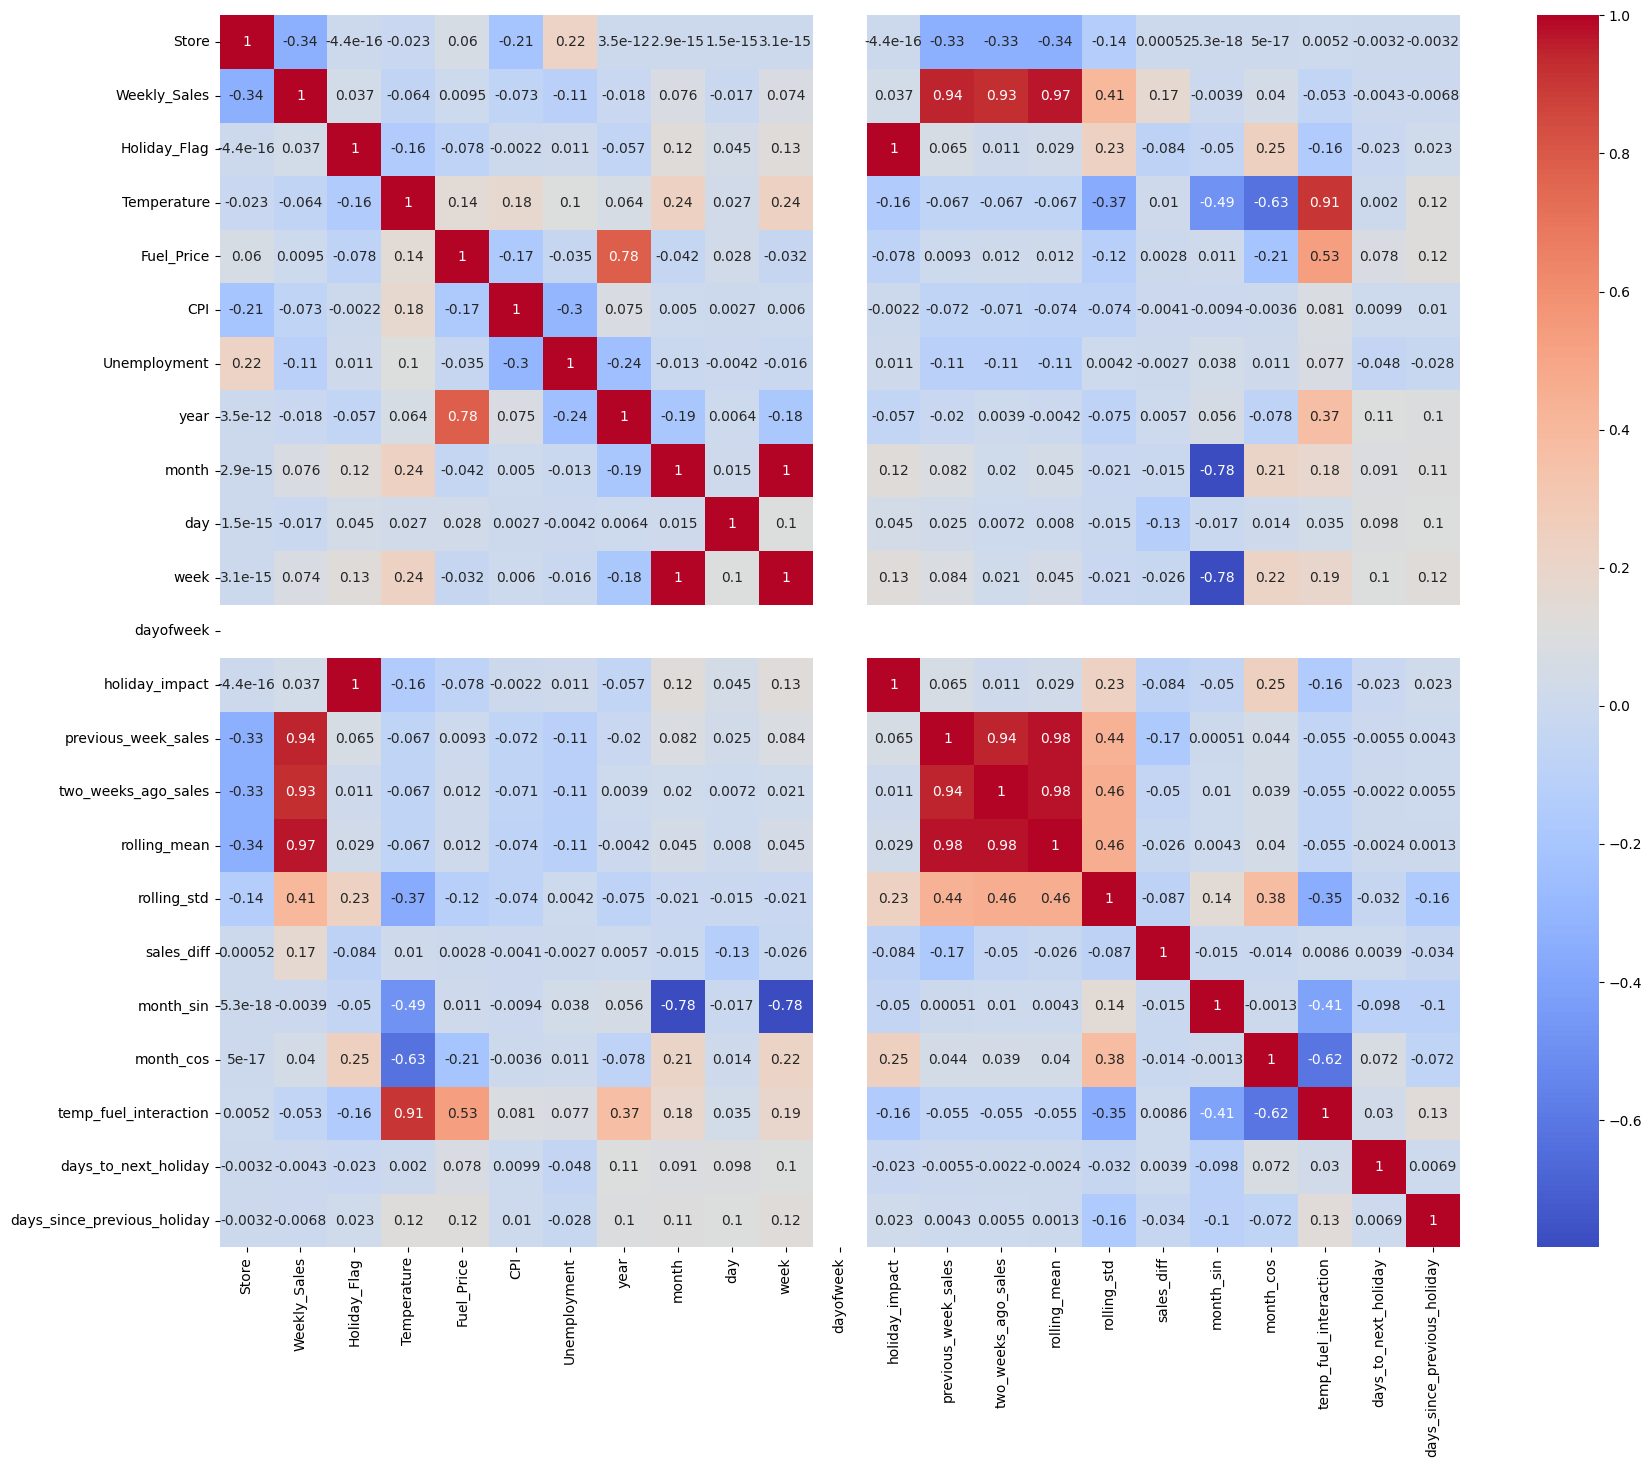

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the figure size (optional)
heatmap.figure.set_size_inches(20, 16)

# Save the heatmap as SVG
heatmap.figure.savefig('heatmap.svg', format='svg')

# Show the heatmap
plt.show()


days of the week no longer seems worth looking into given what the matrix shows

In [44]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Store                        6435 non-null   int64         
 1   Date                         6435 non-null   datetime64[ns]
 2   Weekly_Sales                 6435 non-null   float64       
 3   Holiday_Flag                 6435 non-null   int64         
 4   Temperature                  6435 non-null   float64       
 5   Fuel_Price                   6435 non-null   float64       
 6   CPI                          6435 non-null   float64       
 7   Unemployment                 6435 non-null   float64       
 8   year                         6435 non-null   int64         
 9   month                        6435 non-null   int64         
 10  day                          6435 non-null   int64         
 11  week                         6435 non-null 

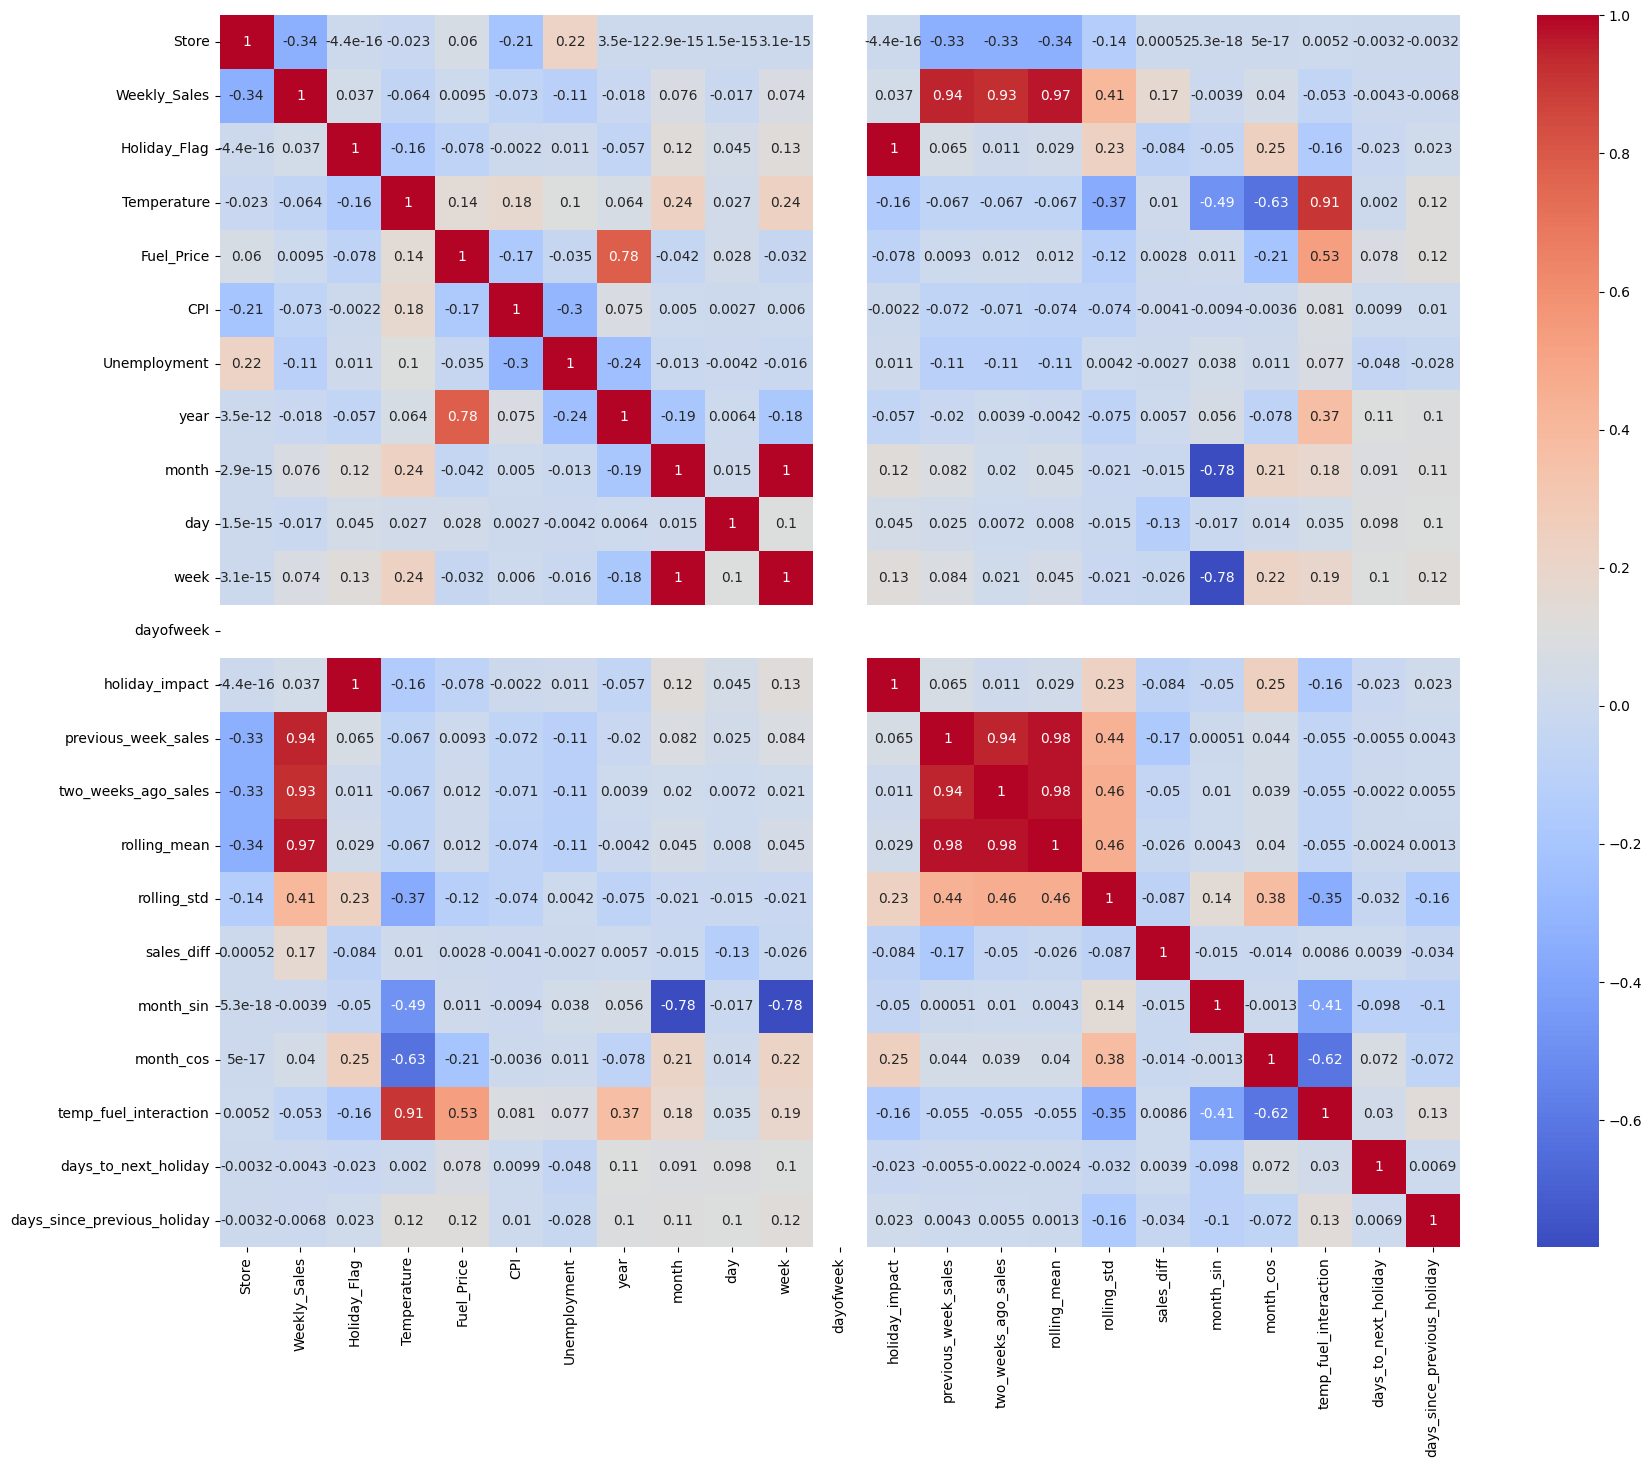

In [41]:
# Create the heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the figure size (optional)
heatmap.figure.set_size_inches(20, 16)

# Save the heatmap as SVG
heatmap.figure.savefig('heatmap.svg', format='svg')

# Show the heatmap
plt.show()


C:\Users\adame\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 24 x 20 in image.
C:\Users\adame\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: heatmap.svg


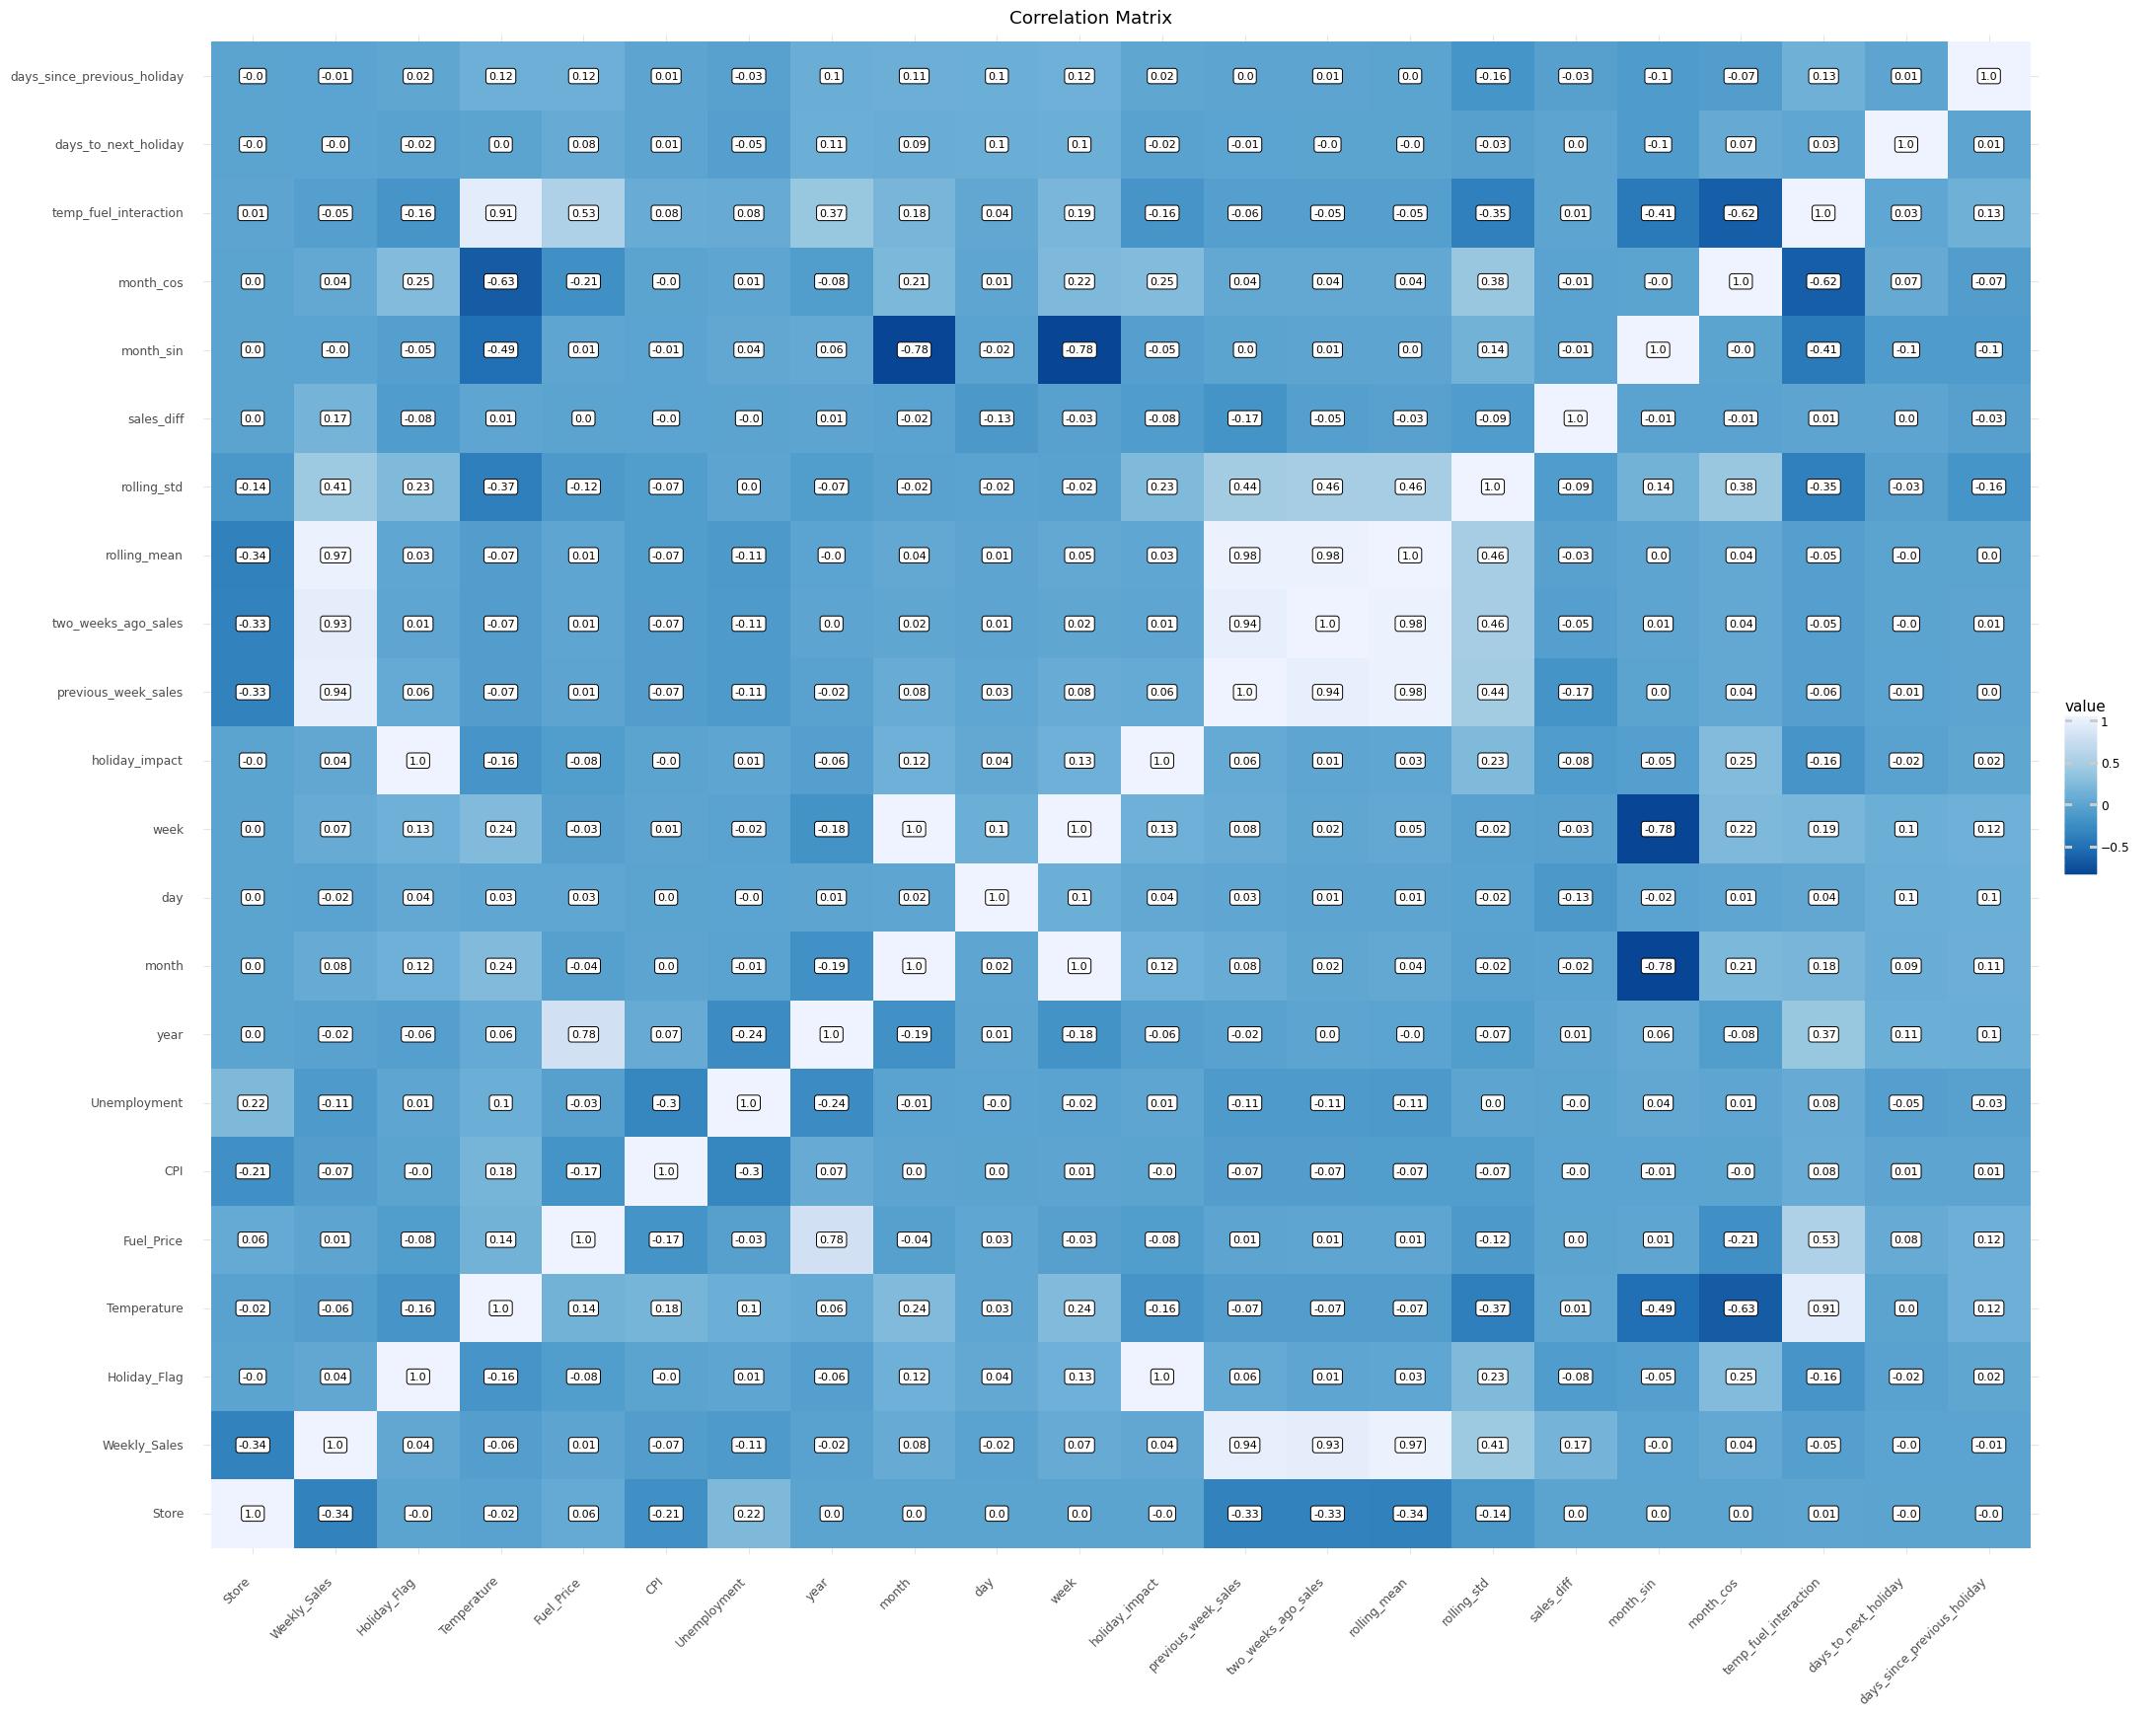

In [50]:
tidy_corr = (
    df
    .corr(numeric_only=True)
    .stack()
    .reset_index(name='value')
    .rename(columns={'level_0': 'var1', 'level_1': 'var2'})
    .assign(lab_text=lambda x: np.round(x['value'], 2))
    .assign(
        var1=lambda x: cat.cat_inorder(x['var1']),
        var2=lambda x: cat.cat_inorder(x['var2'])
    )
)

p = (
    ggplot(tidy_corr, aes(x='var1', y='var2', fill='value')) +
    geom_tile() +
    geom_label(aes(label='lab_text'), fill='white', size=8) +
    scale_fill_distiller() +
    theme_minimal() +
    labs(title='Correlation Matrix', x='', y='') +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(24, 20)
    )
)
# Save the plot as an SVG file
p.save('heatmap.svg', format='svg')

print(p)


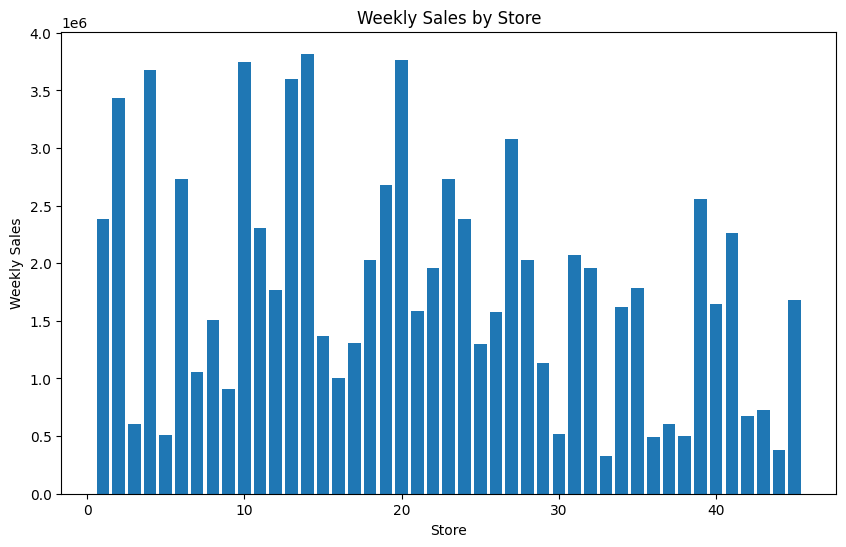

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df['Store'], df['Weekly_Sales'])
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales by Store')
plt.show()

Hypothesis Testing (ANOVA):

In [57]:
import scipy.stats as stats

store1_sales = df['Weekly_Sales'][df['Store'] == 1]
store2_sales = df['Weekly_Sales'][df['Store'] == 2]
store3_sales = df['Weekly_Sales'][df['Store'] == 3]
# Repeat the above line for all the stores

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(store1_sales, store2_sales, store3_sales)
# Include the data arrays for all the stores in the above line

print('ANOVA Results:')
print('F-statistic:', f_stat)
print('p-value:', p_value)


ANOVA Results:
F-statistic: 3262.0703881355357
p-value: 5.243333883141683e-259


Weekly Sales vs. previous_week_sales:

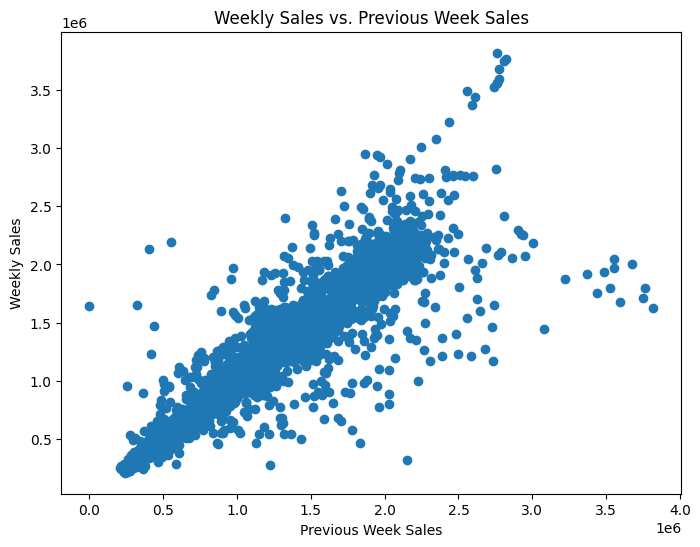

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(df['previous_week_sales'], df['Weekly_Sales'])
plt.xlabel('Previous Week Sales')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Previous Week Sales')
plt.show()

Hypothesis Testing (Correlation):

In [61]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df['previous_week_sales'], df['Weekly_Sales'])
print('Correlation Results:')
print('Correlation coefficient:', corr)
print('p-value:', p_value)


Correlation Results:
Correlation coefficient: 0.9445313107927787
p-value: 0.0


In [ ]:
Weekly Sales during holidays vs. non-holidays:

<Figure size 800x600 with 0 Axes>

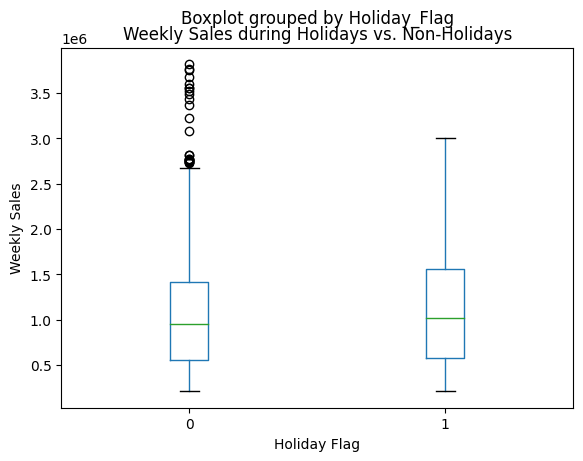

In [62]:
plt.figure(figsize=(8, 6))
df.boxplot(column='Weekly_Sales', by='Holiday_Flag', grid=False)
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales during Holidays vs. Non-Holidays')
plt.show()

In [63]:
from scipy.stats import ttest_ind

holiday_sales = df['Weekly_Sales'][df['Holiday_Flag'] == 1]
non_holiday_sales = df['Weekly_Sales'][df['Holiday_Flag'] == 0]

t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)
print('T-test Results:')
print('t-statistic:', t_stat)
print('p-value:', p_value)

T-test Results:
t-statistic: 2.9608919093259036
p-value: 0.003078699263818616


In [ ]:
Weekly Sales vs. Temperature and Fuel_Price

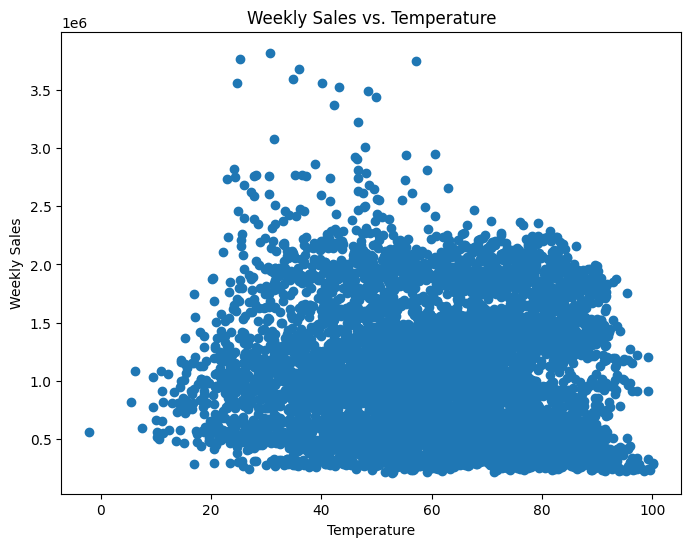

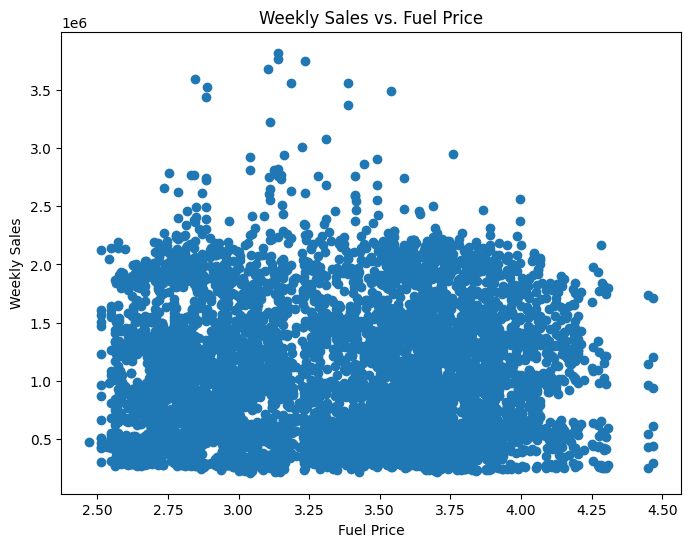

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Temperature'], df['Weekly_Sales'])
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Temperature')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['Fuel_Price'], df['Weekly_Sales'])
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Fuel Price')
plt.show()

In [65]:
corr_temp, p_value_temp = pearsonr(df['Temperature'], df['Weekly_Sales'])
corr_fuel, p_value_fuel = pearsonr(df['Fuel_Price'], df['Weekly_Sales'])

print('Correlation Results:')
print('Temperature - Correlation coefficient:', corr_temp)


Correlation Results:
Temperature - Correlation coefficient: -0.06381001317946959


In [ ]:
Weekly Sales vs. CPI and Unemployment:

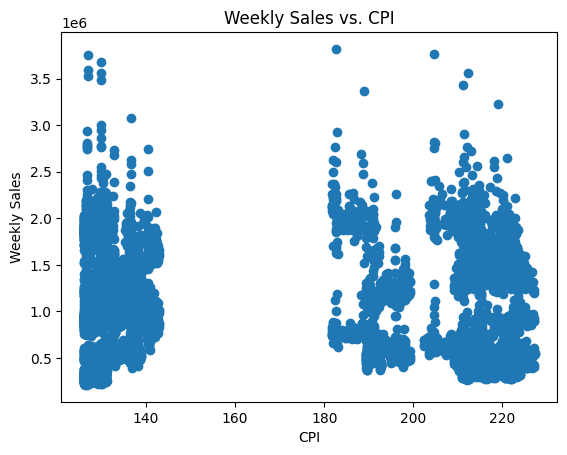

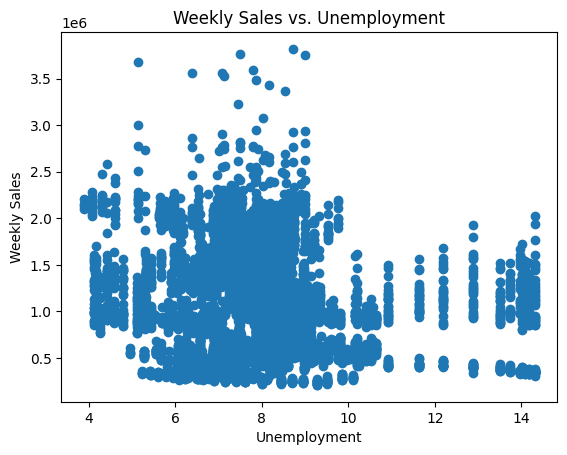

In [66]:
import matplotlib.pyplot as plt

# Scatter plot: CPI vs. Weekly Sales
plt.scatter(df['CPI'], df['Weekly_Sales'])
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. CPI')
plt.show()

# Scatter plot: Unemployment vs. Weekly Sales
plt.scatter(df['Unemployment'], df['Weekly_Sales'])
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Unemployment')
plt.show()

In [67]:
import scipy.stats as stats

# Correlation test: CPI and Weekly Sales
correlation_cpi, p_value_cpi = stats.pearsonr(df['CPI'], df['Weekly_Sales'])
print('Correlation between CPI and Weekly Sales:', correlation_cpi)
print('p-value:', p_value_cpi)

# Correlation test: Unemployment and Weekly Sales
correlation_unemployment, p_value_unemployment = stats.pearsonr(df['Unemployment'], df['Weekly_Sales'])
print('Correlation between Unemployment and Weekly Sales:', correlation_unemployment)
print('p-value:', p_value_unemployment)

Correlation between CPI and Weekly Sales: -0.07263416204017628
p-value: 5.438292612224682e-09
Correlation between Unemployment and Weekly Sales: -0.10617608965795415
p-value: 1.3448365210351757e-17


These correlation tests, using the Pearson correlation coefficient, will provide the strength and significance of the relationships between CPI and Weekly Sales, and Unemployment and Weekly Sales. The correlation coefficient will indicate the direction and strength of the linear relationship, while the p-value will determine if the correlation is statistically significant.

In [84]:
df['Revenue']=df.apply(lambda x :float(x['Weekly_Sales'])-float(x['CPI'])-float(x['Fuel_Price']),axis= 1 )

In [86]:
x=['Holiday_Flag','Store','Temperature','Fuel_Price','CPI','Unemployment','day','month','year','Revenue']

In [87]:
y=['Weekly_Sales']

In [88]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(df[x],df[y], test_size=0.33, random_state=44, shuffle =True)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4311, 10)
X_test shape is  (2124, 10)
y_train shape is  (4311, 1)
y_test shape is  (2124, 1)


In [89]:
#Applying Linear Regression Model 

LinearRegressionModel = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1)
LinearRegressionModel.fit(X_train, y_train)

#Calculating Details
print('Linear Regression Train Score is : ' , LinearRegressionModel.score(X_train, y_train))
print('Linear Regression Test Score is : ' , LinearRegressionModel.score(X_test, y_test))
print('Linear Regression Coef is : ' , LinearRegressionModel.coef_)
print('Linear Regression intercept is : ' , LinearRegressionModel.intercept_)
print('----------------------------------------------------')

Linear Regression Train Score is :  1.0
Linear Regression Test Score is :  1.0
Linear Regression Coef is :  [[ 1.12036217e-14 -1.54032342e-11  3.21134149e-12  1.00000000e+00
   1.00000000e+00 -7.44531254e-12 -3.99981399e-12 -2.52531935e-11
  -1.28174209e-11  1.00000000e+00]]
Linear Regression intercept is :  [2.44472176e-08]
----------------------------------------------------


In [90]:
#Calculating Prediction
y_pred = LinearRegressionModel.predict(X_test)
print('Predicted Value for Linear Regression is : ' , y_pred[:10])

Predicted Value for Linear Regression is :  [[ 477409.3 ]
 [1315118.4 ]
 [ 991969.37]
 [ 341098.08]
 [ 541071.29]
 [ 641763.53]
 [1923223.82]
 [ 503720.98]
 [1545370.16]
 [1418697.05]]


In [91]:
#Calculating Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') 
print('Mean Absolute Error Value is : ', MAEValue)

#Calculating Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average') 
print('Mean Squared Error Value is : ', MSEValue)

#Calculating Median Absolute Error
MdSEValue = median_absolute_error(y_test, y_pred)
print('Median Absolute Error Value is : ', MdSEValue )

Mean Absolute Error Value is :  5.162093242921511e-10
Mean Squared Error Value is :  4.387666558003855e-19
Median Absolute Error Value is :  4.656612873077393e-10
